# Initialization and imports

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, math, time, copy, gc, h5py
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

REPO_ROOT = "../../../"
proj = Path(REPO_ROOT).resolve()

# allow: import ADCNN.*
sys.path.insert(0, str(proj))

# allow: import utils.*  (where utils == ADCNN/utils)
sys.path.insert(0, str(proj / "ADCNN"))

from ADCNN.data.h5tiles import H5TiledDataset
from ADCNN.models.unet_res_se import UNetResSEASPP
from ADCNN.predict import load_model, predict_tiles_to_full
from ADCNN.config import Config
from ADCNN.train import Trainer
from ADCNN.utils.utils import set_seed, split_indices
import ADCNN.evaluation as evaluation
from ADCNN.utils.utils import draw_one_line
from tqdm import tqdm

EPOCHS = 10
batches = 5000
MODEL_CKPT = "../../../checkpoints/Best/ckpt_best.pt"
SAVE_PATH = "../../../checkpoints/Experiments/"

In [2]:
def mark_nn_to_catalog (catalog, predictions, threshold, pixel_gap=10, psf_width=40):
    predictions = predictions >= threshold
    for image_id in catalog["image_id"].unique():
        lab, n = evaluation._label_components_fds(predictions[image_id], pixel_gap=pixel_gap)
        for i, row in catalog[catalog["image_id"]==image_id].iterrows():
            index = np.argwhere((catalog["x"] == row["x"]) & (catalog["y"] == row["y"]) & (catalog["image_id"] == row["image_id"]))[0][0]
            mask = draw_one_line(np.zeros((predictions.shape[1], predictions.shape[2]), dtype=np.uint8), [row["x"], row["y"]], row["beta"], row["trail_length"], true_value=1, line_thickness=int(psf_width/2))
            mask = mask != 0
            intersection = predictions[row["image_id"]] & mask
            lab_ids = np.unique(lab[intersection])
            lab_ids = lab_ids[lab_ids!=0]  # remove background
            lab_removed = np.isin(lab, lab_ids)
            predictions[row["image_id"]][lab_removed] = 0
            if np.any(intersection):
                catalog.at[index, "nn_detected"] = True
            else:
                catalog.at[index, "nn_detected"] = False
    return catalog

def objectwise_confusion (catalog, predictions, threshold, pixel_gap=10, psf_width=40):
    true_positive = 0
    false_negative = 0
    false_positive = 0

    predictions = predictions >= threshold
    for image_id in catalog["image_id"].unique():
        lab, n = evaluation._label_components_fds(predictions[image_id], pixel_gap=pixel_gap)
        predicted_positive = n
        for i, row in catalog[catalog["image_id"]==image_id].iterrows():
            mask = draw_one_line(np.zeros((predictions.shape[1], predictions.shape[2]), dtype=np.uint8), [row["x"], row["y"]], row["beta"], row["trail_length"], true_value=1, line_thickness=int(psf_width/2))
            mask = mask != 0
            intersection = predictions[row["image_id"]] & mask
            lab_ids = np.unique(lab[intersection])
            lab_ids = lab_ids[lab_ids!=0]  # remove background
            lab_removed = np.isin(lab, lab_ids)
            predictions[row["image_id"]][lab_removed] = 0
            if np.any(intersection):
                true_positive += 1
            else:
                false_negative += 1
        false_positive += predicted_positive - true_positive if predicted_positive - true_positive >=0 else 0
    return true_positive, false_positive, false_negative

def evaluate_model_on_catalog (catalog, predictions, ground_truth, threshold):
    catalog = catalog.copy()
    (pix_tp, pix_fp, pix_fn, pix_tn), (_, _, pix_f1, pix_f2) = evaluation.pixelwise_confusion(predictions, ground_truth, thr=threshold)
    obj_tp, obj_fp, obj_fn = objectwise_confusion(catalog, predictions, threshold=threshold, pixel_gap=2, psf_width=40)
    obj_f1 = 2*obj_tp/(2*obj_tp + obj_fp + obj_fn)
    obj_f2 = 5*obj_tp/(5*obj_tp + 4*obj_fn + obj_fp)
    catalog = mark_nn_to_catalog(catalog, predictions, threshold=threshold, pixel_gap=2, psf_width=40)
    results = {
        "pixelwise": {
            "TP": pix_tp,
            "FP": pix_fp,
            "FN": pix_fn,
            "TN": pix_tn,
            "F1": pix_f1,
            "F2": pix_f2
        },
        "objectwise": {
            "TP": obj_tp,
            "FP": obj_fp,
            "FN": obj_fn,
            "TN": -1,
            "F1": obj_f1,
            "F2": obj_f2
        }
    }
    _ = evaluation.plot_detect_hist(catalog, "PSF_mag", bins=12, title="NN detections vs PSF_mag threshold=" + str(threshold))
    _ = evaluation.plot_detect_hist(catalog, "trail_length", bins=12, title="Detections vs trail length threshold="+ str(threshold))
    print_confusion_matrix(results["pixelwise"], title=f"Pixelwise Confusion Matrix @ thr={threshold}")
    print ()
    print_confusion_matrix(results["objectwise"], title=f"Objectwise Confusion Matrix @ thr={threshold}")

    plt.show()

    return results, catalog

def print_confusion_matrix(cm, title="Confusion Matrix"):
    cm = np.array([[cm["TN"], cm["FP"]], [cm["FN"], cm["TP"]]])
    df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"], columns=["Predicted Negative", "Predicted Positive"])
    print(title)
    print (f"F1 Score: {cm[1,1]*2/(cm[1,1]*2 + cm[0,1] + cm[1,0]):.4f}, F2 Score: {cm[1,1]*5/(cm[1,1]*5 + cm[0,1] + cm[1,0]*4):.4f}")
    print(df)

# Data loading and preparation

In [3]:
@dataclass
class BaselineCfg:
    train_h5: str = "/home/karlo/train.h5"
    train_csv: str = "../../../DATA/train.csv"
    test_h5:  str = "../../../DATA/test.h5"
    test_csv: str = "../../../DATA/test.csv"
    tile: int = 128
    seed: int = 1337

    # loader
    batch_size: int = 64
    num_workers: int = 0
    pin_memory: bool = True

    # training
    epochs: int = 15
    lr: float = 3e-4
    weight_decay: float = 1e-4
    pos_weight: float = 8.0            # baseline imbalance handling
    grad_clip: float = 1.0
    amp: bool = True

    # quick eval
    val_every: int = 1
    max_val_batches: int = 60          # keep small for sandbox speed

cfg_data = BaselineCfg()

set_seed(cfg_data.seed)

idx_tr, idx_va = split_indices(cfg_data.train_h5, val_frac=0.1, seed=cfg_data.seed)

ds_tr = H5TiledDataset(cfg_data.train_h5, tile=cfg_data.tile, k_sigma=5.0)
ds_va = H5TiledDataset(cfg_data.train_h5, tile=cfg_data.tile, k_sigma=5.0)
ds_te = H5TiledDataset(cfg_data.test_h5,  tile=cfg_data.tile, k_sigma=5.0)

# Restrict to panels via indices (panels->tiles handled inside H5TiledDataset indices list),
# simplest baseline: just use full tiled dataset and do a tile-level split by panel id.
# We'll filter tiles by panel id membership.
idx_tr_set = set(idx_tr.tolist())
idx_va_set = set(idx_va.tolist())

def filter_tiles_by_panels(base_ds, panel_id_set):
    kept = []
    for k, (pid, r, c) in enumerate(base_ds.indices):
        if pid in panel_id_set:
            kept.append(k)
    return kept

tiles_tr = filter_tiles_by_panels(ds_tr, idx_tr_set)
tiles_va = filter_tiles_by_panels(ds_va, idx_va_set)

class TileSubset(torch.utils.data.Dataset):
    def __init__(self, base, tile_indices):
        self.base = base
        self.tile_indices = np.asarray(tile_indices, dtype=np.int64)
    def __len__(self): return len(self.tile_indices)
    def __getitem__(self, i): return self.base[int(self.tile_indices[i])]

train_ds = TileSubset(ds_tr, tiles_tr)
val_ds   = TileSubset(ds_va, tiles_va)

train_loader = DataLoader(
    train_ds,
    batch_size=cfg_data.batch_size,
    shuffle=True,
    num_workers=cfg_data.num_workers,
    pin_memory=cfg_data.pin_memory,
    persistent_workers=(cfg_data.num_workers > 0),
    prefetch_factor=2 if cfg_data.num_workers > 0 else None,
)
val_loader = DataLoader(
    val_ds,
    batch_size=cfg_data.batch_size,
    shuffle=False,
    num_workers=cfg_data.num_workers,
    pin_memory=cfg_data.pin_memory,
    persistent_workers=(cfg_data.num_workers > 0),
    prefetch_factor=2 if cfg_data.num_workers > 0 else None,
)

test_loader = DataLoader(
    ds_te,
    batch_size=cfg_data.batch_size,
    shuffle=False,
    num_workers=cfg_data.num_workers,
    pin_memory=cfg_data.pin_memory,
    persistent_workers=(cfg_data.num_workers > 0),
    prefetch_factor=2 if cfg_data.num_workers > 0 else None,
)

test_catalog = pd.read_csv(cfg_data.test_csv)
train_catalog = pd.read_csv(cfg_data.train_csv)
with h5py.File(cfg_data.test_h5, "r") as _f:
    gt_test = _f["masks"][:].astype(np.uint8)
print("Train tiles:", len(train_ds), "Val tiles:", len(val_ds), "Test tiles:", len(ds_te))

Train tiles: 737280 Val tiles: 81920 Test tiles: 51200


# Baseline model

In [4]:
cfg_baseline = Config()
cfg_baseline.train.warmup_epochs = 2
cfg_baseline.train.head_epochs = 2
cfg_baseline.train.tail_epochs = 2
cfg_baseline.train.max_epochs = EPOCHS

cfg_baseline.train.warmup_batches = int(batches/10)
cfg_baseline.train.head_batches = int(batches/10)
cfg_baseline.train.tail_batches = int(batches/10)
cfg_baseline.train.long_batches = batches
cfg_baseline.train.val_every = EPOCHS

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_baseline = UNetResSEASPP(in_ch=1, out_ch=1).to(device)
trainer = Trainer(device=device)
model_baseline, thr, summary = trainer.train_full_probe(
        model_baseline, train_loader=train_loader, val_loader=val_loader,
        seed=cfg_baseline.train.seed,
        init_head_prior=cfg_baseline.train.init_head_prior,
        warmup_epochs=cfg_baseline.train.warmup_epochs, warmup_batches=cfg_baseline.train.warmup_batches,
        warmup_lr=cfg_baseline.train.warmup_lr, warmup_pos_weight=cfg_baseline.train.warmup_pos_weight,
        head_epochs=cfg_baseline.train.head_epochs, head_batches=cfg_baseline.train.head_batches,
        head_lr=cfg_baseline.train.head_lr, head_pos_weight=cfg_baseline.train.head_pos_weight,
        tail_epochs=cfg_baseline.train.tail_epochs, tail_batches=cfg_baseline.train.tail_batches,
        tail_lr=cfg_baseline.train.tail_lr, tail_pos_weight=cfg_baseline.train.tail_pos_weight,
        max_epochs=cfg_baseline.train.max_epochs, val_every=cfg_baseline.train.val_every,
        base_lrs=cfg_baseline.train.base_lrs, weight_decay=cfg_baseline.train.weight_decay,
        thr_beta=cfg_baseline.train.thr_beta, long_batches=cfg_baseline.train.long_batches,
        thr_pos_rate_early=cfg_baseline.train.thr_pos_rate_early, thr_pos_rate_late=cfg_baseline.train.thr_pos_rate_late,
        save_best_to=SAVE_PATH+"Best/Baseline.pt", save_last_to=SAVE_PATH+"Last/Baseline.pt"
    )

Warmup EP1 BATCH 500[WARMUP] ep1 loss 0.1744 | F1 0.000 P 0.000 R 0.002
Warmup EP2 BATCH 500[WARMUP] ep2 loss 0.1497 | F1 0.009 P 0.004 R 0.469
[WARMUP VALIDATION] AUC 0.877 P 0.011 R 0.570 F 0.022 | thr=0.299
Head-only training batch 500[HEAD] ep1 loss 0.0860 | F1 0.023 P 0.012 R 0.632
Head-only training batch 500[HEAD] ep2 loss 0.0722 | F1 0.031 P 0.016 R 0.349
[TAIL] ep2 batch 500[TAIL PROBE VALIDATION] AUC 0.808 P 0.000 R 0.000 F 0.000 | thr=0.299 [tail-probe] loss≈0.1122 [quick_prob_stats] train @ thr0: {'P': 0.0, 'R': 0.0, 'F': 0.0, 'pos_mean': 0.008, 'neg_mean': 0.002}
 Epoch 1 / 10, Batch 5000[EP01] loss 0.4263 | train P 0.002 R 0.000 F 0.001 | pos≈0.033 neg≈0.009 | 502.6s
[VAL ep1] AUC 0.864 P 0.012 R 0.567 F 0.024 | thr=0.025 | pos_rate≈0.061
 Epoch 2 / 10, Batch 5000[EP02] loss 0.4259 | train P 0.005 R 0.468 F 0.010 | pos≈0.055 neg≈0.009 | 494.6s
 Epoch 3 / 10, Batch 5000[EP03] loss 0.4256 | train P 0.017 R 0.625 F 0.033 | pos≈0.098 neg≈0.009 | 494.9s
[VAL ep3] AUC 0.858 P 0

In [6]:
model_baseline = load_model(SAVE_PATH+"Last/Baseline.pt")
p_baseline = predict_tiles_to_full(cfg_data.test_h5, test_loader, model_baseline, tile=cfg_data.tile)
model_baseline.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_baseline.shape)

Loaded model from: ../../../checkpoints/Experiments/Last/Baseline.pt
Predictions shape: (50, 4000, 4072)


Pixelwise Confusion Matrix @ thr=0.5
F1 Score: 0.3023, F2 Score: 0.3468
                 Predicted Negative  Predicted Positive
Actual Negative           812268111             1144474
Actual Positive              607765              379650

Objectwise Confusion Matrix @ thr=0.5
F1 Score: 0.4975, F2 Score: 0.4996
                 Predicted Negative  Predicted Positive
Actual Negative                  -1                 503
Actual Positive                 489                 491


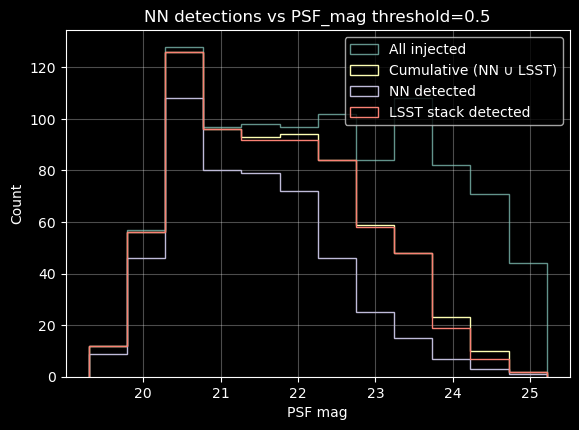

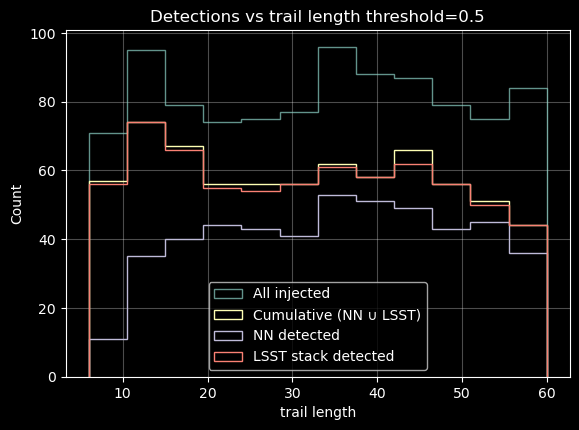

In [7]:
results_baseline, cat_baseline = evaluate_model_on_catalog(test_catalog, p_baseline, gt_test, threshold=0.5)

# Idea 1: Curriculum training biased to LSST-missed injections

In [8]:
cfg_curriculum = Config()
cfg_curriculum.train.warmup_epochs = 2
cfg_curriculum.train.head_epochs = 2
cfg_curriculum.train.tail_epochs = 2
cfg_curriculum.train.max_epochs = EPOCHS

cfg_curriculum.train.warmup_batches = int(batches/10)
cfg_curriculum.train.head_batches = int(batches/10)
cfg_curriculum.train.tail_batches = int(batches/10)
cfg_curriculum.train.val_every = EPOCHS
cfg_curriculum.train.long_batches = batches

In [9]:
import math
from pathlib import Path
import numpy as np
import pandas as pd
import h5py
import torch
from torch.utils.data import Sampler, DataLoader

def get_h5_shape(h5_path: str):
    with h5py.File(h5_path, "r") as f:
        N, H, W = f["images"].shape
    return N, H, W

def compute_tile_grid(H, W, tile):
    Hb = math.ceil(H / tile)
    Wb = math.ceil(W / tile)
    return Hb, Wb

def bbox_tiles_touched(x, y, R, tile, Hb, Wb):
    # conservative bbox [x-R, x+R] × [y-R, y+R] mapped to tile coords
    x0, x1 = x - R, x + R
    y0, y1 = y - R, y + R
    c0 = int(math.floor(x0 / tile))
    c1 = int(math.floor(x1 / tile))
    r0 = int(math.floor(y0 / tile))
    r1 = int(math.floor(y1 / tile))
    # clamp to valid tile grid
    c0 = max(0, min(Wb - 1, c0))
    c1 = max(0, min(Wb - 1, c1))
    r0 = max(0, min(Hb - 1, r0))
    r1 = max(0, min(Hb - 1, r1))
    return r0, r1, c0, c1

def build_hard_tile_mask_from_csv(
    base_ds,                 # H5TiledDataset built on train.h5
    csv_path: str,           # train.csv
    tile: int,
    margin: float = 20.0,    # pixels; tune
    use_integrated_mag: bool = False,  # unused; placeholder if you want future filters
):
    """
    Returns:
      hard_mask_base: np.bool_ array length len(base_ds) (tile-level),
                      True if tile overlaps ≥1 LSST-missed object bbox.
    """
    # Base dataset tiling metadata
    N, H, W = base_ds.N, base_ds.H, base_ds.W
    Hb, Wb = compute_tile_grid(H, W, tile)

    # Map (image_id,r,c) -> base tile index k
    base_map = {(i, r, c): k for k, (i, r, c) in enumerate(base_ds.indices)}

    df = pd.read_csv(csv_path)
    required = {"image_id", "x", "y", "trail_length", "stack_detection"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"train.csv missing columns: {sorted(missing)}")

    # Keep LSST-missed objects
    missed = df[df["stack_detection"].astype(int) == 0].copy()
    if len(missed) == 0:
        print("WARNING: no LSST-missed objects found (stack_detection==0).")
    # Sanity: image_id range
    if missed["image_id"].min() < 0 or missed["image_id"].max() >= N:
        raise ValueError(f"image_id out of range for train.h5: N={N}, "
                         f"min={missed['image_id'].min()}, max={missed['image_id'].max()}")

    hard_mask = np.zeros(len(base_ds), dtype=bool)

    # Mark tiles touched by conservative bbox per object
    for row in missed.itertuples(index=False):
        i = int(getattr(row, "image_id"))
        x = float(getattr(row, "x"))
        y = float(getattr(row, "y"))
        L = float(getattr(row, "trail_length"))
        R = 0.5 * L + float(margin)

        r0, r1, c0, c1 = bbox_tiles_touched(x, y, R, tile, Hb, Wb)
        for r in range(r0, r1 + 1):
            for c in range(c0, c1 + 1):
                k = base_map.get((i, r, c), None)
                if k is not None:
                    hard_mask[k] = True

    return hard_mask

# --- configure paths for your notebook ---
TRAIN_H5 = cfg_data.train_h5
TRAIN_CSV = cfg_data.train_csv  # if train.csv sits next to train.h5
# If not, set explicitly:
# TRAIN_CSV = "../../../DATA/train.csv"

print("TRAIN_H5:", TRAIN_H5)
print("TRAIN_CSV:", TRAIN_CSV)

TRAIN_H5: /home/karlo/train.h5
TRAIN_CSV: ../../../DATA/train.csv


In [10]:
# Use num_workers=0 for notebook stability (as you already discovered)
cfg_data.num_workers = 0

base_ds = H5TiledDataset(TRAIN_H5, tile=cfg_data.tile, k_sigma=5.0)

# Tune margin (pixels). Start conservative; 20–40 is typical for safety.
MARGIN_PIX = 30.0
hard_mask_base = build_hard_tile_mask_from_csv(
    base_ds=base_ds,
    csv_path=TRAIN_CSV,
    tile=cfg_data.tile,
    margin=MARGIN_PIX,
)

print("Base tiles:", len(base_ds))
print("Hard tiles (LSST-missed overlap):", int(hard_mask_base.sum()))
print("Hard fraction:", float(hard_mask_base.mean()))


Base tiles: 819200
Hard tiles (LSST-missed overlap): 15294
Hard fraction: 0.01866943359375


In [11]:
ds_tr = base_ds
ds_va = base_ds

# Rebuild your splits (panel split -> tile indices)
idx_tr, idx_va = split_indices(cfg_data.train_h5, val_frac=0.1, seed=cfg_data.seed)
idx_tr_set = set(idx_tr.tolist())
idx_va_set = set(idx_va.tolist())

def filter_tiles_by_panels(base_ds, panel_id_set):
    kept = []
    for k, (pid, r, c) in enumerate(base_ds.indices):
        if pid in panel_id_set:
            kept.append(k)
    return kept

def filter_tiles_by_truth(h5_path, tiled_ds, tile_indices, *, min_pos_pix=1):
    """
    Keep only those tile indices whose truth mask contains at least min_pos_pix positive pixels.
    Works with H5TiledDataset tiling order via tiled_ds.indices.
    """
    tile_indices = np.asarray(tile_indices, dtype=np.int64)
    kept = []

    with h5py.File(h5_path, "r") as f:
        Y = f["masks"]
        H, W = Y.shape[1:]
        t = int(tiled_ds.tile)

        for idx in tqdm(tile_indices, desc="Filtering hard tiles by truth"):
            i, r, c = tiled_ds.indices[int(idx)]
            r0, c0 = r * t, c * t
            r1, c1 = min(r0 + t, H), min(c0 + t, W)

            y = Y[i, r0:r1, c0:c1]
            if np.count_nonzero(y) >= min_pos_pix:
                kept.append(int(idx))

    return np.asarray(kept, dtype=np.int64)

tiles_tr = filter_tiles_by_panels(ds_tr, idx_tr_set)
tiles_va = filter_tiles_by_panels(ds_va, idx_va_set)

class TileSubset(torch.utils.data.Dataset):
    def __init__(self, base, tile_indices):
        self.base = base
        self.tile_indices = np.asarray(tile_indices, dtype=np.int64)
    def __len__(self): return len(self.tile_indices)
    def __getitem__(self, i): return self.base[int(self.tile_indices[i])]

train_ds = TileSubset(ds_tr, tiles_tr)
val_ds   = TileSubset(ds_va, tiles_va)

# Subset hard mask aligned to train_ds indices (indices are base indices)
hard_mask_train = hard_mask_base[train_ds.tile_indices]
hard_idx_raw = np.asarray(np.flatnonzero(hard_mask_train), dtype=np.int64)
hard_idx = filter_tiles_by_truth(cfg_data.train_h5, ds_tr, hard_idx_raw, min_pos_pix=1)

# total number of training tiles
num_tiles = len(train_ds)

# build a boolean mask from the FILTERED hard_idx
hard_mask = np.zeros(num_tiles, dtype=bool)
hard_mask[hard_idx] = True

# everything not hard is "other"
other_idx = np.flatnonzero(~hard_mask)

print("Train tiles:", len(train_ds))
print("Train hard tiles:", len(hard_idx))
print("Train other tiles:", len(other_idx))
print("Train hard fraction:", float(hard_mask_train.mean()))


Filtering hard tiles by truth: 100%|██████████| 13744/13744 [00:00<00:00, 16338.85it/s]

Train tiles: 737280
Train hard tiles: 727
Train other tiles: 736553
Train hard fraction: 0.018641493055555555


In [12]:
def p_hard_linear(epoch, p0, p1, e_start, e_end):
    if epoch <= e_start:
        return p0
    if epoch >= e_end:
        return p1
    t = (epoch - e_start) / max(e_end - e_start, 1e-12)
    return p0 + (p1 - p0) * t

def p_hard_sigmoid(epoch, p0, p1, e_mid, width):
    # sigmoid ramp from p0->p1
    z = (epoch - e_mid) / max(width, 1e-12)
    s = 1.0 / (1.0 + math.exp(-z))
    return p0 + (p1 - p0) * s

class CurriculumBatchSampler(Sampler[list[int]]):
    """
    Batch sampler that mixes hard and other tiles with epoch-dependent p_hard.
    Call set_epoch(ep) each epoch (Trainer already does this for DDP samplers; we mimic it).
    """
    def __init__(
        self,
        hard_indices: np.ndarray,
        other_indices: np.ndarray,
        batch_size: int,
        seed: int = 1337,
        schedule: str = "linear",
        p1: float = 0.70,   # target hard fraction late
        # linear params
        e_start: int = 6,
        e_end: int = 12,
        # sigmoid params
        e_mid: int = 9,
        width: float = 2.0,
        drop_last: bool = True,
    ):
        self.hard = np.asarray(hard_indices, dtype=np.int64)
        self.other = np.asarray(other_indices, dtype=np.int64)
        self.batch_size = int(batch_size)
        self.seed = int(seed)
        self.schedule = str(schedule)
        self.p1 = float(p1)
        self.e_start = int(e_start)
        self.e_end = int(e_end)
        self.e_mid = int(e_mid)
        self.width = float(width)
        self.drop_last = bool(drop_last)

        if len(self.hard) == 0:
            raise ValueError("No hard indices available (hard set empty).")
        if len(self.other) == 0:
            raise ValueError("No other indices available (other set empty).")

        # baseline hard fraction
        self.p0 = len(self.hard) / (len(self.hard) + len(self.other))
        self.epoch = 0

    def set_epoch(self, epoch: int):
        self.epoch = int(epoch)

    def _p_hard(self):
        if self.schedule == "linear":
            return float(p_hard_linear(self.epoch, self.p0, self.p1, self.e_start, self.e_end))
        elif self.schedule == "sigmoid":
            return float(p_hard_sigmoid(self.epoch, self.p0, self.p1, self.e_mid, self.width))
        else:
            raise ValueError(f"Unknown schedule={self.schedule} (use 'linear' or 'sigmoid')")

    def __iter__(self):
        rng = np.random.default_rng(self.seed + self.epoch)
        hard = rng.permutation(self.hard)
        other = rng.permutation(self.other)

        ph = self._p_hard()
        nh = int(round(ph * self.batch_size))
        nh = max(1, min(self.batch_size - 1, nh))
        no = self.batch_size - nh

        # Cycle through pools if one runs out
        hi = oi = 0
        n_batches = (len(self.hard) + len(self.other)) // self.batch_size
        if not self.drop_last:
            n_batches = math.ceil((len(self.hard) + len(self.other)) / self.batch_size)

        for _ in range(n_batches):
            if hi + nh > len(hard):
                hard = rng.permutation(self.hard); hi = 0
            if oi + no > len(other):
                other = rng.permutation(self.other); oi = 0
            batch = np.concatenate([hard[hi:hi+nh], other[oi:oi+no]])
            rng.shuffle(batch)
            hi += nh
            oi += no
            yield batch.tolist()

    def __len__(self):
        return (len(self.hard) + len(self.other)) // self.batch_size


In [13]:
# Baseline loader (unbiased shuffle)
train_loader_baseline = DataLoader(
    train_ds,
    batch_size=cfg_data.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)

val_loader = DataLoader(
    val_ds,
    batch_size=cfg_data.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

# Curriculum loader (epoch-dependent mixture)
# Choose schedule="linear" or "sigmoid"
schedule = "linear"  # or "linear"
batch_sampler = CurriculumBatchSampler(
    hard_indices=hard_idx,
    other_indices=other_idx,
    batch_size=cfg_data.batch_size,
    seed=cfg_data.seed,
    schedule=schedule,
    p1=0.20,      # late hard fraction target
    e_start = cfg_curriculum.train.warmup_epochs + cfg_curriculum.train.head_epochs + cfg_curriculum.train.tail_epochs,    # for linear
    e_end=cfg_curriculum.train.warmup_epochs + cfg_curriculum.train.head_epochs + cfg_curriculum.train.tail_epochs + cfg_curriculum.train.max_epochs,     # for linear
    e_mid=9,      # for sigmoid
    width=2.0,    # for sigmoid
    drop_last=True
)

train_loader_curriculum = DataLoader(
    train_ds,
    batch_sampler=batch_sampler,
    num_workers=0,
    pin_memory=False,
)

print("Curriculum schedule:", schedule)
print("p0 (natural hard frac):", batch_sampler.p0)
print("p1 (target late):", batch_sampler.p1)


Curriculum schedule: linear
p0 (natural hard frac): 0.0009860568576388889
p1 (target late): 0.2


In [14]:
def estimate_batch_hard_fraction(loader, hard_mask_train, n_batches=3):
    fracs = []
    it = iter(loader)
    for _ in range(n_batches):
        batch = next(it)  # (xb, yb)
        # we cannot see indices from loader directly, so we estimate using batch_sampler logic:
        # For curriculum loader, we can probe its batch_sampler directly:
        fracs.append(np.nan)
    return fracs

# Better: probe the batch_sampler output directly
def probe_sampler(bs: CurriculumBatchSampler, hard_set: set[int], n_batches=3):
    out = []
    for bi, idxs in zip(range(n_batches), iter(bs)):
        nh = sum((i in hard_set) for i in idxs)
        out.append(nh / len(idxs))
    return out

hard_set = set(hard_idx.tolist())
batch_sampler.set_epoch(0)
print("Epoch 0 hard fractions:", probe_sampler(batch_sampler, hard_set, n_batches=5))
batch_sampler.set_epoch(10)
print("Epoch 10 hard fractions:", probe_sampler(batch_sampler, hard_set, n_batches=5))


Epoch 0 hard fractions: [0.015625, 0.015625, 0.015625, 0.015625, 0.015625]
Epoch 10 hard fractions: [0.078125, 0.078125, 0.078125, 0.078125, 0.078125]


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = UNetResSEASPP(in_ch=1, out_ch=1).to(device)

trainer = Trainer(device=device)

model1, thr, summary = trainer.train_full_probe(
    model1,
    train_loader=train_loader_curriculum,
    val_loader=val_loader,
    seed=cfg_curriculum.train.seed,
    init_head_prior=cfg_curriculum.train.init_head_prior,

    warmup_epochs=cfg_curriculum.train.warmup_epochs,
    warmup_batches=cfg_curriculum.train.warmup_batches,
    warmup_lr=cfg_curriculum.train.warmup_lr,
    warmup_pos_weight=cfg_curriculum.train.warmup_pos_weight,

    head_epochs=cfg_curriculum.train.head_epochs,
    head_batches=cfg_curriculum.train.head_batches,
    head_lr=cfg_curriculum.train.head_lr,
    head_pos_weight=cfg_curriculum.train.head_pos_weight,

    tail_epochs=cfg_curriculum.train.tail_epochs,
    tail_batches=cfg_curriculum.train.tail_batches,
    tail_lr=cfg_curriculum.train.tail_lr,
    tail_pos_weight=cfg_curriculum.train.tail_pos_weight,

    max_epochs=cfg_curriculum.train.max_epochs,
    long_batches=cfg_curriculum.train.long_batches,
    val_every=cfg_curriculum.train.val_every,
    base_lrs=cfg_curriculum.train.base_lrs,
    weight_decay=cfg_curriculum.train.weight_decay,

    thr_beta=cfg_curriculum.train.thr_beta,
    thr_pos_rate_early=cfg_curriculum.train.thr_pos_rate_early,
    thr_pos_rate_late=cfg_curriculum.train.thr_pos_rate_late,
    save_best_to=SAVE_PATH+"Best/idea1.pt", save_last_to=SAVE_PATH+"Last/idea1.pt"
)

print("Final thr:", float(thr))
print("Summary:", summary)


Warmup EP1 BATCH 500[WARMUP] ep1 loss 0.2359 | F1 0.014 P 0.007 R 0.268
Warmup EP2 BATCH 500[WARMUP] ep2 loss 0.2010 | F1 0.025 P 0.013 R 0.531
[WARMUP VALIDATION] AUC 0.886 P 0.011 R 0.547 F 0.022 | thr=0.221
Head-only training batch 500[HEAD] ep1 loss 0.0714 | F1 0.025 P 0.013 R 0.249
Head-only training batch 500[HEAD] ep2 loss 0.0598 | F1 0.046 P 0.025 R 0.319
[TAIL] ep2 batch 500[TAIL PROBE VALIDATION] AUC 0.881 P 0.000 R 0.000 F 0.000 | thr=0.221 [tail-probe] loss≈0.1260 [quick_prob_stats] train @ thr0: {'P': 0.0, 'R': 0.0, 'F': 0.0, 'pos_mean': 0.022, 'neg_mean': 0.008}
 Epoch 1 / 10, Batch 5000[EP01] loss 0.4667 | train P 0.028 R 0.027 F 0.028 | pos≈0.058 neg≈0.026 | 464.4s
[VAL ep1] AUC 0.887 P 0.011 R 0.585 F 0.022 | thr=0.076 | pos_rate≈0.065
 Epoch 2 / 10, Batch 5000[EP02] loss 0.4738 | train P 0.024 R 0.361 F 0.045 | pos≈0.075 neg≈0.030 | 462.3s
 Epoch 3 / 10, Batch 5000[EP03] loss 0.4871 | train P 0.013 R 0.284 F 0.026 | pos≈0.068 neg≈0.038 | 479.4s
 Epoch 4 / 10, Batch 50

KeyboardInterrupt: 

In [16]:
model_1 = load_model(SAVE_PATH+"Last/idea1.pt")
p_1 = predict_tiles_to_full(cfg_data.test_h5, test_loader, model_1, tile=cfg_data.tile)
model_1.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_1.shape)

Loaded model from: ../../../checkpoints/Experiments/Last/idea1.pt
Predictions shape: (50, 4000, 4072)


Pixelwise Confusion Matrix @ thr=0.05
F1 Score: 0.0142, F2 Score: 0.0343
                 Predicted Negative  Predicted Positive
Actual Negative           724878889            88533696
Actual Positive              349000              638415

Objectwise Confusion Matrix @ thr=0.05
F1 Score: 0.0103, F2 Score: 0.0254
                 Predicted Negative  Predicted Positive
Actual Negative                  -1              172855
Actual Positive                  79                 901


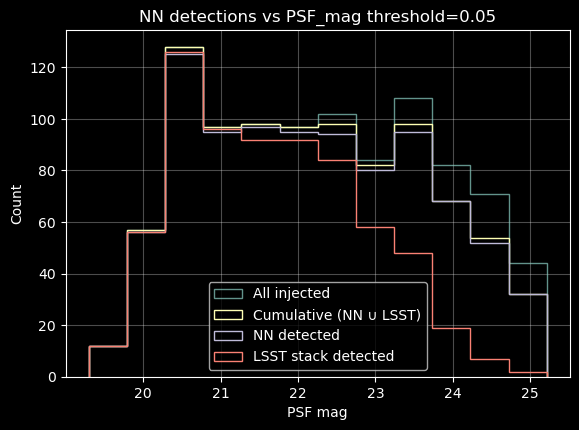

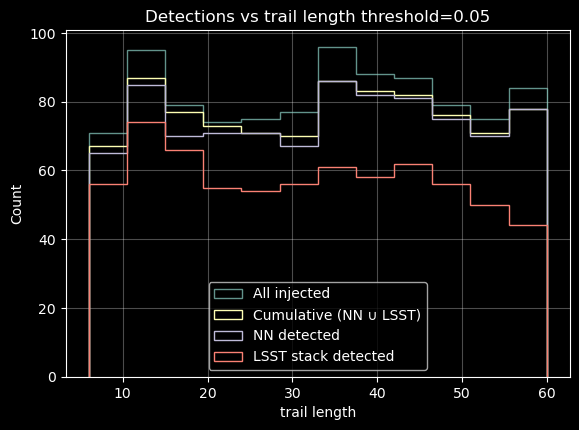

In [20]:
results_baseline, cat_baseline = evaluate_model_on_catalog(test_catalog, p_1, gt_test, threshold=0.05)

In [ ]:
def tile_truth_stats(h5_path, tiled_ds, tile_indices):
    """
    Compute truth purity statistics for a set of tile indices.
    """
    any_pos = []
    pos_frac = []
    pos_pix  = []

    with h5py.File(h5_path, "r") as f:
        Y = f["masks"]
        H, W = Y.shape[1:]

        for idx in tqdm(tile_indices, desc="Scanning tiles"):
            i, r, c = tiled_ds.indices[idx]
            t = tiled_ds.tile

            r0, c0 = r*t, c*t
            r1, c1 = min(r0+t, H), min(c0+t, W)

            y = Y[i, r0:r1, c0:c1]
            npos = np.count_nonzero(y)

            any_pos.append(npos > 0)
            pos_pix.append(npos)
            pos_frac.append(npos / y.size)

    return {
        "any_pos": np.array(any_pos),
        "pos_pix": np.array(pos_pix),
        "pos_frac": np.array(pos_frac),
    }

# all tile indices
all_idx = np.arange(len(ds_tr.indices))

# non-hard tiles
hard_set = set(hard_idx)
easy_idx = np.array([i for i in all_idx if i not in hard_set])

# compute stats
hard_stats = tile_truth_stats(cfg_data.train_h5, ds_tr, hard_idx)
easy_stats = tile_truth_stats(cfg_data.train_h5, ds_tr, easy_idx)

def summarize(name, stats):
    print(f"\n{name}")
    print("-"*len(name))
    print(f"tiles: {len(stats['any_pos'])}")
    print(f"tiles with ANY truth: {stats['any_pos'].mean()*100:.2f}%")
    print(f"mean pos pixel fraction: {stats['pos_frac'].mean():.6f}")
    print(f"median pos pixel fraction: {np.median(stats['pos_frac']):.6f}")
    print(f"mean positive pixels per tile: {stats['pos_pix'].mean():.2f}")
    print(f"median positive pixels per tile: {np.median(stats['pos_pix']):.2f}")

summarize("HARD tiles (LSST-missed)", hard_stats)
summarize("EASY tiles (rest)", easy_stats)


# Idea 2: Loss biased toward LSST-missed tiles